# CS 136 day02 Lab: Bernoulli distributions and ML estimation


## Outline

* **Part 1: Numerical experiments with probabilities**
* **Part 2: Numerical experiments with logarithms of probabilities**

* **Part 3: Different ways to implement the Bern likelihood in NumPy**
* * Compare correctness
* * Compare speed
* * Compare NaN issues

* **Part 4: Visualizing the Bern likelihood as a function of $\mu$**
* **Part 5: Visualizing and Maximizing the Bern likelihood under alternative parameterization**

## Takeaways

* Try to work in log-space whenever taking products of many probabilities
* Vectorization of Python code matters a lot to get good speed
* Avoiding not-a-number (NaN) issues require careful thought
* Maximum likelihood optimization can be done via numerical grid search as well as by calculus
* Visualization is an excellent way to understand the behavior of distributions


In [ ]:
import numpy as np
import scipy.stats
import time
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

# Part 1: Numerical explorations

Let's imagine we observe a dataset of $N$ bits (each binary bit is 0 or 1).

The bits seem to be randomly generated.

We'd like to compute the probability of all the observed values, $x_1, \ldots x_N$.

If we assume each bit is the outcome of an independent Bernoulli r.v. with the same (shared) parameter $\mu$, we can compute this as

$$
p( x_1, \ldots x_N) = \prod_{n=1}^N \mu^{x_n} (1-\mu)^{1-x_n}
$$

using the standard PMF of the Bernoulli

This is getting complex, so let's simplify by assuming that our model is good, and it allocates 0.9 probability to each of the $x_n$ events that are observed.

Our simplified calculation is now:

\begin{align}
p( x_1, \ldots x_N) &\approx \prod_{n=1}^N 0.9
\\
&\approx 0.9^N
\end{align}

Can we compute this easily?

Let's look at several ways we could calculate $0.9^N$

In [ ]:
pt9 = np.asarray(0.9, np.float32)

### Option a: Use star-star operator (**)

In [ ]:
for N in [100, 1000, 10000, 100000]:
    print(pt9 ** N)

2.656132852400217e-05
1.7478249495597477e-46
0.0
0.0


### Option b: use np.power to compute

In [ ]:
for N in [100, 1000, 10000, 100000]:
    print(np.power(pt9, N))

2.656132852400217e-05
1.7478249495597477e-46
0.0
0.0


### Option c: Repeat the product N times

In [ ]:
for N in [100, 1000, 10000, 100000]:
    array_of_pt9_N = pt9 * np.ones(N, dtype=np.float32)
    print(np.prod(array_of_pt9_N))

2.6561329e-05
6e-45
6e-45
6e-45


## Discussion 1a: What's going on here?

What problems do you notice? Why do they occur?

Note that mathematically, it should always be true that if N < M, then 0.9^N > 0.9^M. 

> <font color='red'> 
    We observe that all of the 3 options a-c above have a problem in that expressions with N=10^4 and 10^5 evaluate to the same value, despite the fact that the latter should be way lower than the former. Essentially, we see that the product of many small positive numbers will <b>underflow</b> using 32-bit precision arithmetic.
</font>

## Exercise 1b: What would change if you used float64 instead of float32 precision?

Try it out!

> <font color='red'> 
    Trying out 64-bit does help somewhat (raises the lowest value of N at which problems occur), but there are still underflow problems because the precision is still finite.
</font>

## Discussion 1c: What are the practical takeaways of the numerical issues here?

If you were to be analyzing large datasets (with 1000s and 1000s of entries), can we assign each one a "probability" between 0 and 1 and ask about joint probabilities by taking products?


> <font color='red'> 
    Products of small positive values are unreliable above say N=100 or so.
    To avoid, we should maybe try to ask our question a different way, by using logarithms (as in Part 2)
</font>

# Part 2: Numerical explorations with log


Now we'll consider tracking the *natural log* of probability above

\begin{align}
\log \left[ p( x_1, \ldots x_N)  \right] &\approx \log \left[ \prod_{n=1}^N 0.9 \right]
\\
&= \sum_{n=1}^N \log 0.9 = N \log 0.9
\end{align}

Let's try it for various values of $N$

In [ ]:
for N in [100, 1000, 10000, 100000]:
    print(N * np.log(pt9))

-10.536054521799088
-105.36054521799088
-1053.6054521799088
-10536.054521799088


## Discussion 2a: What's going on here?

Do you see the same problems as in Discussion 1a?

Note that mathematically, it should always be true that if N < M, then $\log(0.9^N) > \log(0.9^M)$

> <font color='red'> 
    Here we see that comparisons of the relative values work as expected for $N$ values up to several billion at least.
    There should be little trouble handling most datasets.
    Naturally, keep in mind that there is some N value at which N \log 0.9 will overflow the finite-precision of a computer, but that N value will be enormous (and likely you'll have bigger problems with a dataset of that size than how to compute its log probability)
</font>

## Discussion 2b: What are the practical takeaways of the numerical issues here?

If you were to be analyzing large datasets (with 1000s and 1000s of entries), which should we look at:
    
* $p( x_1, \ldots x_N)$
* $\log p( x_1, \ldots x_N)$



> <font color='red'> 
    We should almost always prefer the *log* of the PMF / PDF when doing numerical computing. 
    We'll be able to handle much bigger datasets without numerical errors. (Plus the math itself is often easier that way as well)
</font>

# Part 3: Computing the log likelihood of a Bernoulli

Two ways to write the formula for a Bernoulli's log PMF mathematically

\begin{align}
\log p( x | \mu) &= \begin{cases}
\log \mu & ~\text{if}~ x =1
\\
\log (1-\mu) & ~\text{if}~ x =0
\end{cases} && \text{"A: Select case only"}
\\
&= x \log \mu + (1-x) \log (1-\mu) && \text{"B: Weighted product of cases"}
\end{align}

Now, while these are equivalent mathematically, they may each have different properties when implemented in code.

## Discussion 3a: Pros / Cons

What do you suggest are the pros and cons of implementing each of the two views of the formula above?

> <font color='red'> 
 Looking for: Formula A might be faster (you compute only 1 of the 2 terms in Formula B). Formula A is simpler to implement (maybe). Formula B is easier to handle in math derivation (no if statements, just multiplies and adds).
</font>

## Implementations with forloop

We'll first implement formulas A and B using for loops to traverse a large dataset of size $N$

In [ ]:
def calc_bern_log_pmf__A_forloop(x_N, mu):
    ''' Compute bernoulli log PMF of dataset at given parameter
    
    Args
    ----
    x_N : 1D array of type int32
        Contains binary values
    mu : scalar float, between 0.0 and 1.0
        Probability of the positive outcome in Bern model
        
    Returns
    -------
    logpmf : scalar float
        Log probability of the entire dataset of N points
    '''
    logpmf = 0.0
    N = x_N.size
    for n in range(N):
        if x_N[n] == 1:
            logpmf += np.log(mu)
        else:
            logpmf += np.log(1-mu)
    return logpmf

In [ ]:
def calc_bern_log_pmf__B_forloop(x_N, mu):
    ''' Compute bernoulli log PMF of dataset at given parameter
    
    Args
    ----
    x_N : 1D array of type int32
        Contains binary values
    mu : scalar float, between 0.0 and 1.0
        Probability of the positive outcome in Bern model
        
    Returns
    -------
    logpmf : scalar float
        Log probability of the entire dataset of N points
    '''
    logpmf = 0.0
    N = x_N.size
    for n in range(N):
        logpmf += x_N[n] * np.log(mu) + (1-x_N[n]) * np.log(1-mu)
    return logpmf

## Implementations with vectorization

We'll now implement formulas A and B using **vectorized** numpy code for a dataset of size $N$.

This code has NO PYTHON-LEVEL LOOPS. Instead, the work done in the "loop" is performed in compiled routines like `np.sum`, so that the work is done very fast.

In [ ]:
def calc_bern_log_pmf__A_vectorized(x_N, mu):
    ''' Compute bernoulli log PMF of dataset at given parameter
    
    Args
    ----
    x_N : 1D array of type int32
        Contains binary values
    mu : scalar float, between 0.0 and 1.0
        Probability of the positive outcome in Bern model
        
    Returns
    -------
    logpmf : scalar float
        Log probability of the entire dataset of N points
    '''
    count1 = np.sum(x_N==1)
    count0 = np.sum(x_N==0)
    logpmf = 0.0
    if count1 > 0:
        logpmf += count1 * np.log(mu) 
    if count0 > 0:
        logpmf += count0 * np.log(1-mu)
    return logpmf

In [ ]:
def calc_bern_log_pmf__B_vectorized(x_N, mu):
    ''' Compute bernoulli log PMF of dataset at given parameter
    
    Args
    ----
    x_N : 1D array of type int32
        Contains binary values
    mu : scalar float, between 0.0 and 1.0
        Probability of the positive outcome in Bern model
        
    Returns
    -------
    logpmf : scalar float
        Log probability of the entire dataset of N points
    '''
    logpmf = np.sum(x_N * np.log(mu) + (1-x_N) * np.log(1-mu))
    return logpmf

## Example 3b: Verify correctness of these implementations with "typical" inputs


Let's ask each of the 4 functions above for the logpmf of the same dataset with same mu value.

We should observe the *same* logpmf return value if the 4 implementations are each correct.

### Verify correctness with N=20 and mu = 0.5


In [ ]:
x_N = np.random.choice(2, size=20)
mu = 0.5

print("x_N:" + str(x_N))

formula_types = ['A', 'B']
loop_types = ['forloop', 'vectorized']
for loop in loop_types:
    for formula in formula_types:
        # ask Python for the function in local workspace with the provided name
        calc_bern_log_lik = locals()['calc_bern_log_pmf__%s_%s' % (formula, loop)]
        print(calc_bern_log_lik(x_N, mu), calc_bern_log_lik.__name__)

x_N:[1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0]
-13.862943611198906 calc_bern_log_pmf__A_forloop
-13.862943611198906 calc_bern_log_pmf__B_forloop
-13.862943611198906 calc_bern_log_pmf__A_vectorized
-13.862943611198906 calc_bern_log_pmf__B_vectorized


### Verify correctness with N=30 and mu = 0.345

In [ ]:
x_N = np.random.choice(2, size=30)
mu = 0.345

print("x_N:" + str(x_N))

formula_types = ['A', 'B']
loop_types = ['forloop', 'vectorized']
for loop in loop_types:
    for formula in formula_types:
        # ask Python for the function in local workspace with the provided name
        calc_bern_log_lik = locals()['calc_bern_log_pmf__%s_%s' % (formula, loop)]
        print(calc_bern_log_lik(x_N, mu), calc_bern_log_lik.__name__)

x_N:[1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 1 1 0]
-23.59214521667271 calc_bern_log_pmf__A_forloop
-23.59214521667271 calc_bern_log_pmf__B_forloop
-23.59214521667272 calc_bern_log_pmf__A_vectorized
-23.592145216672712 calc_bern_log_pmf__B_vectorized


## Discussion 3b: Did our correctness tests pass?

> <font color='red'> 
 Looking for: yes, all 4 functions gave same logpmf value given same input, as expected.
</font>

## Example 3c: Assess speed of each implementation on large datasets

We'll take the median of 30 trials for each function, to be sure that we get "typical" timing not an outlier.

In [ ]:
n_trials = 30
N = 10000

x_N = np.random.choice(2, size=N)
mu = 0.345

print("When N=%d and x_N - %s" % (N, str(x_N)))

formula_types = ['A', 'B']
loop_types = ['forloop', 'vectorized']
for loop in loop_types:
    for formula in formula_types:
        # ask Python for the function in local workspace with the provided name
        calc_bern_log_lik = locals()['calc_bern_log_pmf__%s_%s' % (formula, loop)]
        
        runtimes_in_millisec = list()
        for rep in range(n_trials):
            start_time_millisec = time.time() * 1000
            ans = calc_bern_log_lik(x_N, mu)
            elapsed_time_millisec = time.time() * 1000 - start_time_millisec
            runtimes_in_millisec.append(elapsed_time_millisec)
            
        time_str = "% 11.3f milliseconds" % (np.median(runtimes_in_millisec))
        print(time_str, calc_bern_log_lik.__name__)

When N=10000 and x_N - [1 0 0 ... 1 1 0]
      9.040 milliseconds calc_bern_log_pmf__A_forloop
     21.217 milliseconds calc_bern_log_pmf__B_forloop
      0.045 milliseconds calc_bern_log_pmf__A_vectorized
      0.038 milliseconds calc_bern_log_pmf__B_vectorized


## Discussion 3c: Are these timing results what you expect? How much faster is vectorized code?

> <font color='red'> 
 Looking for: Vectorized code seems to be about 1000x faster. Avoid for loops like the plague!
        Formula B does seem to be more costly than Formula A, since in Formula B we compute 2x the terms and thus do 2x the work (even though one term is always zero)
</font>

## Example 3d: Testing edgecases for numerical correctness

Look at the two test inputs below.

Which of the 4 implementations are correct for each edge case?


In [ ]:
x_N = np.asarray([1, 1, 1, 1], dtype=np.int32)
mu = 1.0

print("x_N:" + str(x_N))

formula_types = ['A', 'B']
loop_types = ['forloop', 'vectorized']
for loop in loop_types:
    for formula in formula_types:
        # ask Python for the function in local workspace with the provided name
        calc_bern_log_lik = locals()['calc_bern_log_pmf__%s_%s' % (formula, loop)]
        print(calc_bern_log_lik(x_N, mu), calc_bern_log_lik.__name__)

x_N:[1 1 1 1]
0.0 calc_bern_log_pmf__A_forloop
nan calc_bern_log_pmf__B_forloop
0.0 calc_bern_log_pmf__A_vectorized
nan calc_bern_log_pmf__B_vectorized


In [ ]:
x_N = np.asarray([0, 0, 1], dtype=np.int32)
mu = 0.0

print("x_N:" + str(x_N))

formula_types = ['A', 'B']
loop_types = ['forloop', 'vectorized']
for loop in loop_types:
    for formula in formula_types:
        # ask Python for the function in local workspace with the provided name
        calc_bern_log_lik = locals()['calc_bern_log_pmf__%s_%s' % (formula, loop)]
        print(calc_bern_log_lik(x_N, mu), calc_bern_log_lik.__name__)

x_N:[0 0 1]
-inf calc_bern_log_pmf__A_forloop
nan calc_bern_log_pmf__B_forloop
-inf calc_bern_log_pmf__A_vectorized
nan calc_bern_log_pmf__B_vectorized


## Discussion 3d: Edgecase analysis

> <font color='red'> 
    Formula A is correct in both cases. There should never be NaN values when mu is exactly 0.0. NaN values always indicate a problem in implementation correctness.
</font>

## Discussion 3e: Edge cases in practice?

Are the nans we saw in 3d something to worry about in a real application? How could you avoid this?

> <font color='red'> 
    Looking for: the NaN values might break your gradient descent optimization and cause it to return nonsense results.
    Getting these details right matters.
</font>

# Part 4: Visualizing the likelihood as a function of parameter $\mu$ 

## Draw fake data from our model

In [ ]:
# Define a random generator object, with specific seed for reproducibility
prng = np.random.RandomState(101)

# Settings
N = 100000   # num bit values to observe

# Pick a "true" mu value for data generation
true_mu = 0.789

# Sample N examples from Bernoulli given mu
x_N = scipy.stats.bernoulli(true_mu).rvs(size=N, random_state=prng)
# OR...
# x_N = prng.rand(N) < true_mu # another equivalent way to draw N samples from a Bernoulli with parameter 'true_mu'

In [ ]:
# Print first 20 values of data...
x_N[:20]

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

## Plot of likelihood PMF value as a function of parameter mu

We'll make a separate plot as we see more and more data (1 bit, 3 bits, 10 bits, ...)

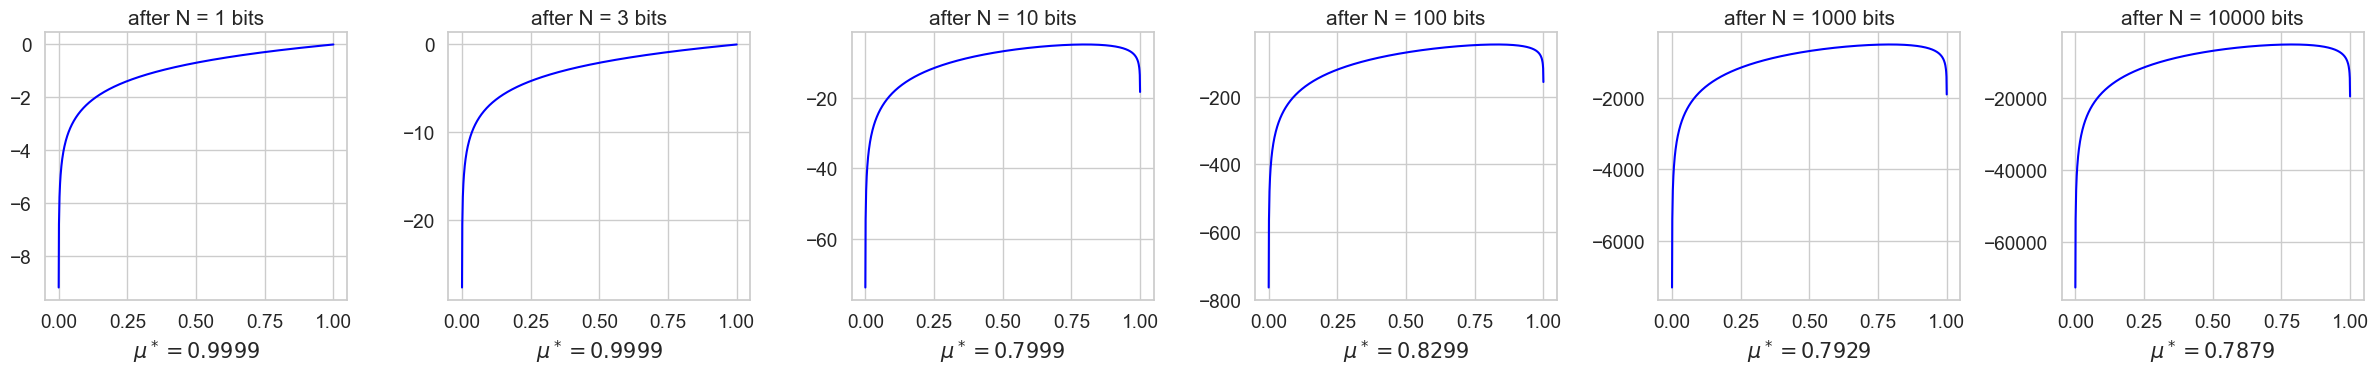

In [ ]:
Npartial_list = [1, 3, 10, 100, 1000, 10000]
L = len(Npartial_list)

fig, axgrid = plt.subplots(
    nrows=1, ncols=L,
    sharex=True, sharey=False,
    figsize=(4 * L, 4))

# Define a grid of mu values at which we'll evaluate the likelihood
G = 1001
mu_grid_G = np.linspace(0.0001, 0.9999, G)

for aa, Npartial in enumerate(Npartial_list):

    log_lik_G = np.zeros(G)
    for gg in range(G):
        log_lik_G[gg] = calc_bern_log_pmf__A_vectorized(x_N[:Npartial], mu_grid_G[gg])
                                    
    axgrid[aa].plot(mu_grid_G, log_lik_G, 'b-')
    axgrid[aa].set_title("after N = %d bits" % Npartial)

    ggstar = np.argmax(log_lik_G)
    mustar = mu_grid_G[ggstar]
    axgrid[aa].set_xlabel(r"$\mu^* = %.4f$" % mustar)
    
plt.tight_layout();

## Discussion 4a: Analyze your visuals

What do you notice about the plots above as the number of observed coins $N$ increases?

What happens to the shape of the curve?
What happens to the y-axis scale? 

> <font color='red'> 
    The shape of the curve is an upside-down U with maximum at the preferred $\mu$ value.
    The "steepness" of the curve increases as N gets bigger, since there is more and more data to favor some mu values over others.
    As N increases, the location of the optimal $\mu$ converges to the "true" mu value.
</font>

## Discussion 4b: How to find the maximum?

In the notes, we discussed how we can use calculus to solve for the "maximum likelihood" value of $\mu$.

Above, however, we used a different procedure (see the line `mustar = ...`). What is this procedure? How does it work? 

What are the pros/cons of the procedure above vs. the calculus procedure?

> <font color='red'> 
    Our plots use a numerical grid of G evenly spaced mu values between 0.0001 and 0.9999.
    Here, we find the maximum among this grid of possiblities, just by exhaustively calculating the likelihood at each of the G values and selecting the largest one.
   </font>
   
> <font color='red'> 
    Pros: This is easier to implement than a gradient descent procedure or an exact formula.
</font>

    
> <font color='red'> 
    Cons: in high dimensions, this is infeasible since we'd need huge number of grid points.
</font>

# Part 5: Alternative parameterization using sigmoid of a real value

Let $r \in \mathbb{R}$ be an UNCONSTRAINED real value parameter

Define the sigmoid function as the S-shaped function that maps any $r$ value to between 0.0 and 1.0

$$
\sigma(r) = \frac{1}{1 + e^{-r}}
$$

We visualize this function below

In [ ]:
from scipy.special import expit as sigmoid # use a convenient implementation already in scipy

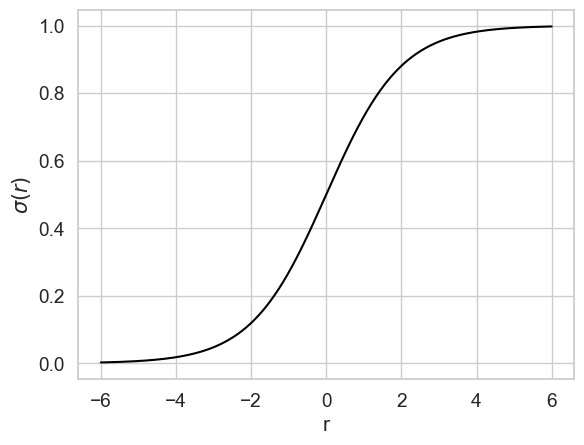

In [ ]:
r_grid_G = np.linspace(-6, +6, G)

plt.plot(r_grid_G, sigmoid(r_grid_G), 'k-');
plt.xlabel('r')
plt.ylabel('$\sigma(r)$');


Let's consider a model for our $N$ coins that looks like this

$$
p( x_1, \ldots x_N) = \prod_{n=1}^N \text{BernPMF}( x_n | \sigma(r) )
$$

We can visualize the likelihood as a function of $r$ for the same fake dataset as in part 4.

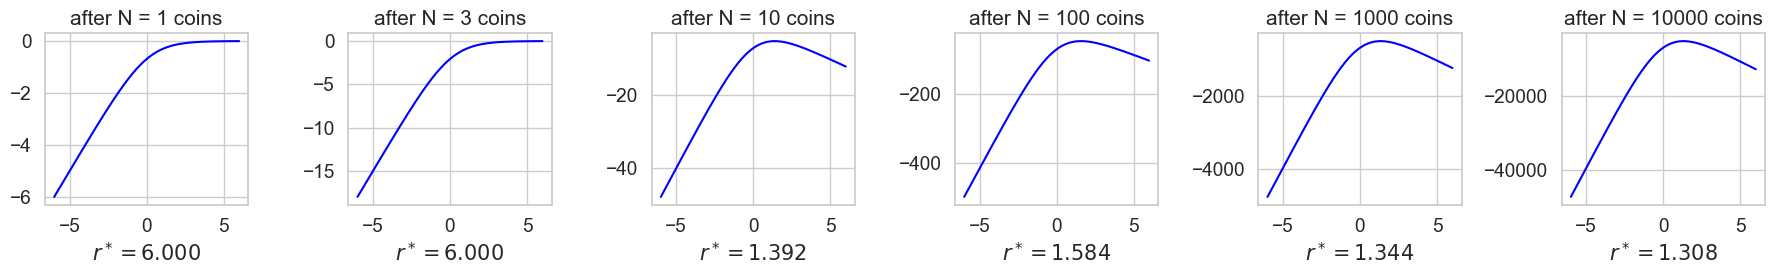

In [ ]:
L = len(Npartial_list)

fig, axgrid = plt.subplots(
    nrows=1, ncols=L,
    sharex=True, sharey=False,
    figsize=(3 * L, 3))

for aa, Npartial in enumerate(Npartial_list):

    log_lik_G = np.zeros(G)
    for gg in range(G):
        proba_from_r_gg = sigmoid(r_grid_G[gg])
        log_lik_G[gg] = calc_bern_log_pmf__A_vectorized(
            x_N[:Npartial], proba_from_r_gg)
                                    
    axgrid[aa].plot(r_grid_G, log_lik_G, 'b-')
    axgrid[aa].set_title("after N = %d coins" % Npartial)

    ggstar = np.argmax(log_lik_G)
    rstar = r_grid_G[ggstar]
    axgrid[aa].set_xlabel(r"$r^* = %.3f$" % rstar)
    
plt.tight_layout();

## Discussion 5a: Is the ML estimate the same before and after reparameterization?

One of the key advantages of ML estimation is that you won't get meaningfully different answers depending on how you choose to parameterize the problem.

Is this seen in practice here? What might account for the subtle differences?

> <font color='red'> 
   The optimal $\mu^*$ value (using our grid search) was 0.788
   </font>
   
> <font color='red'> 
    The optimal $r^*$ value (using our grid search) is 1.308
    <br />
    If we apply a sigmoid to our optimal rstar, we get 0.787, which is off by a pretty negligible amount
</font>

The differences are likely due to the finite grid we are searching.
If we used a finer grid, we should get closer agreement.

In [ ]:
rstar

1.3079999999999998

In [ ]:
sigmoid(rstar)

0.7871782910626082